In [ ]:
import tensorflow as tf
import zipfile
import os

In [ ]:
pip install mlp-mixer-keras

In [ ]:
# @title Unziping
def extract_zip(zip_file_path, extract_to_folder):
    """
    Extracts a ZIP file into a specified folder.

    Parameters:
    zip_file_path (str): The path to the ZIP file.
    extract_to_folder (str): The folder where the contents should be extracted.
    """
    # Ensure the extraction folder exists
    if not os.path.exists(extract_to_folder):
        os.makedirs(extract_to_folder)

    # Open the ZIP file and extract all its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
        print(f"Extracted all files from {zip_file_path} to {extract_to_folder}")

In [ ]:
# Example usage
zip_file_path = '/content/drive/MyDrive/Projects/dataset.zip'  # Replace with the path to your ZIP file
extract_to_folder = '/content/drive/MyDrive/Projects/dataset'  # Replace with the path to the folder where you want to extract files
extract_zip(zip_file_path, extract_to_folder)


Extracted all files from /content/drive/MyDrive/Projects/dataset.zip to /content/drive/MyDrive/Projects/dataset


###Data Processing

path_to_your_data/
    ├── cls0/
    │   ├── img1.jpg
    │   ├── img2.jpg
    │   └── ...
    ├── cls1/
    │   ├── img1.jpg
    │   ├── img2.jpg
    │   └── ...
    └── cls2/
        ├── img1.jpg
        ├── img2.jpg
        └── ...


In [ ]:
def load_classified_dataset(directory, image_size=(256, 256), batch_size=32):
    """
    Creates a TensorFlow dataset from images organized in subdirectories (each representing a class).

    Parameters:
    directory (str): Path to the directory containing subdirectories of images.
    image_size (tuple): The size to resize images to after loading.
    batch_size (int): Number of images per batch.
    label_mode='categorical': Labels are one-hot encoded arrays.
    label_mode=None: No labels are included in the dataset.
    label_mode='int': Labels are integers (0, 1, 2, ...) representing class indices
    Returns:
    tf.data.Dataset: A dataset containing images and corresponding labels.
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        label_mode='categorical',  # 'int', 'categorical', or None for unlabeled data
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True  # Shuffle the dataset
    )

    return dataset

# Example usage:
directory = '/content/drive/MyDrive/Projects/dataset'
dataset = load_classified_dataset(directory)

# Iterating through the dataset
for images, labels in dataset.take(1):  # Take 1 batch for demonstration
    print(images.shape)  # Output: (batch_size, image_size[0], image_size[1], 3)
    print(labels)  # Output: (batch_size,) array of labels corresponding to cls0, cls1, cls2

Found 4326 files belonging to 3 classes.
(32, 256, 256, 3)
tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]], shape=(32, 3), dtype=float32)


In [ ]:
Class_names = dataset.class_names
print(class_names)  # Output: ['cls0', 'cls1', 'cls2']

##Data Scaling

In [ ]:
def preprocess_image(image, label):
    # Custom preprocessing logic
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image, label

dataset = dataset.map(preprocess_image)

In [ ]:
for images, labels in dataset.take(1):  # Take 1 batch for demonstration
    print(images.shape)  # Output: (batch_size, image_size[0], image_size[1], 3)
    print(labels)  # Output: (batch_size,) array of labels corresponding to cls0, cls1, cls2

(32, 256, 256, 3)
tf.Tensor([2 1 2 0 2 1 2 2 2 2 0 1 2 1 0 0 0 2 2 0 1 0 0 0 0 0 2 0 2 0 1 1], shape=(32,), dtype=int32)


# Data Spliting

In [ ]:
# Splitting dataset into training and testing
def split_dataset(dataset, validation_split=0.2, seed=123):
    dataset_size = len(dataset)
    val_size = int(dataset_size * validation_split)
    train_size = dataset_size - val_size

    # Use `tf.data.experimental.sample_from_datasets` to create a validation dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

train_dataset, val_dataset = split_dataset(dataset)

# Model

In [ ]:
from mlp_mixer_keras import MlpMixerModel
import numpy as np

# Assuming train_dataset and val_dataset are defined

# Extract the shape from the dataset
for image_batch, label_batch in dataset.take(1):
    input_shape = image_batch.shape[1:]  # Extract input shape from the first batch

# Define the MLP-Mixer model
model = MlpMixerModel(
    input_shape=input_shape,
    num_classes=3,  # Number of classes based on your dataset
    num_blocks=4,
    patch_size=8,
    hidden_dim=32,
    tokens_mlp_dim=64,
    channels_mlp_dim=128,
    use_softmax=True
)

In [ ]:
# Define callbacks
callbacks = [
     tf.keras.callbacks.ModelCheckpoint(
        '/content/Weights/best_model.keras',  # Change to .keras extension
        save_best_only=True,                  # Save only the best model
        monitor='val_accuracy',              # Monitor validation accuracy
        mode='max'                           # Mode to look for the best value (max or min)
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,                     # Number of epochs to wait for improvement
        monitor='val_accuracy',         # Monitor validation accuracy
        mode='max',                     # Mode to look for the best value (max or min)
        restore_best_weights=True       # Restore model weights from the best epoch
    )
]
# Define Precision metric
precision_metric = tf.keras.metrics.Precision(name='precision')

# Define Recall metric
recall_metric = tf.keras.metrics.Recall(name='recall')

# Compile the model with multiple metrics
model.compile(
    loss='categorical_crossentropy',  # Use this for integer labels
    optimizer='adam',
    metrics=['accuracy', precision_metric, recall_metric]
)

# Example training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,                               # Set the number of epochs as needed
    batch_size=32,                           # Adjust batch size as needed
    callbacks=callbacks                      # Include the callbacks if any
)



Epoch 1/10
109/109 [==============================] - 108s 938ms/step - loss: 1.0615 - accuracy: 0.4366 - precision: 0.5690 - recall: 0.1419 - val_loss: 0.9007 - val_accuracy: 0.5549 - val_precision: 0.6753 - val_recall: 0.3126
Epoch 2/10
109/109 [==============================] - 101s 924ms/step - loss: 0.8055 - accuracy: 0.6439 - precision: 0.7188 - recall: 0.5378 - val_loss: 0.7447 - val_accuracy: 0.6826 - val_precision: 0.7353 - val_recall: 0.5967
Epoch 3/10
109/109 [==============================] - 101s 923ms/step - loss: 0.6817 - accuracy: 0.7076 - precision: 0.7586 - recall: 0.6353 - val_loss: 0.7216 - val_accuracy: 0.6957 - val_precision: 0.7284 - val_recall: 0.6527
Epoch 4/10
109/109 [==============================] - 101s 926ms/step - loss: 0.5922 - accuracy: 0.7494 - precision: 0.7916 - recall: 0.7036 - val_loss: 0.6360 - val_accuracy: 0.7220 - val_precision: 0.7516 - val_recall: 0.6933
Epoch 5/10
109/109 [==============================] - 101s 920ms/step - loss: 0.5249 - a

# Plot the model architecture

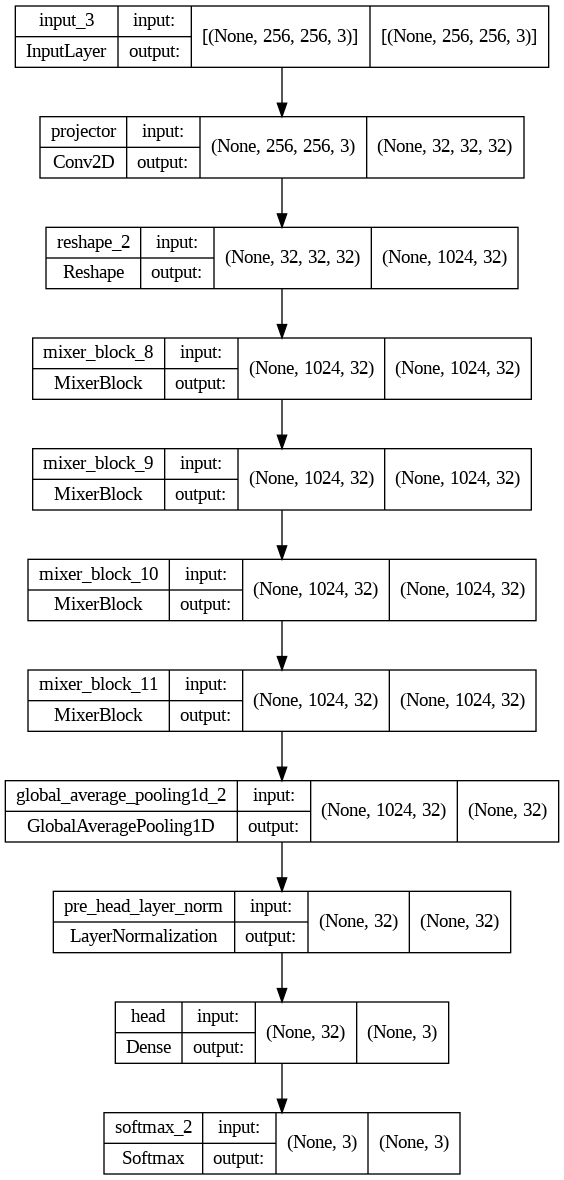

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# Iterating through the dataset
""""
for images, labels in train_dataset.take(1):  # Take 1 batch for demonstration
    print(images.shape)  # Output: (batch_size, image_size[0], image_size[1], 3)
    print(labels)  # Output: (batch_size,) array of labels corresponding to cls0, cls1, cls2
"""

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(val_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Save the model as .h5 format
model_save_path = '/content/Weights/best_model.h5'  # Define the path where you want to save the model
model.save(model_save_path)
print(f'Model saved to {model_save_path}')

27/27 [==============================] - 21s 325ms/step - loss: 0.6261 - accuracy: 0.7542 - precision: 0.7719 - recall: 0.7470
Test Accuracy: 0.7542
Test Precision: 0.7719
Test Recall: 0.7470
Model saved to /content/Weights/best_model.h5


# Plotting Graphs

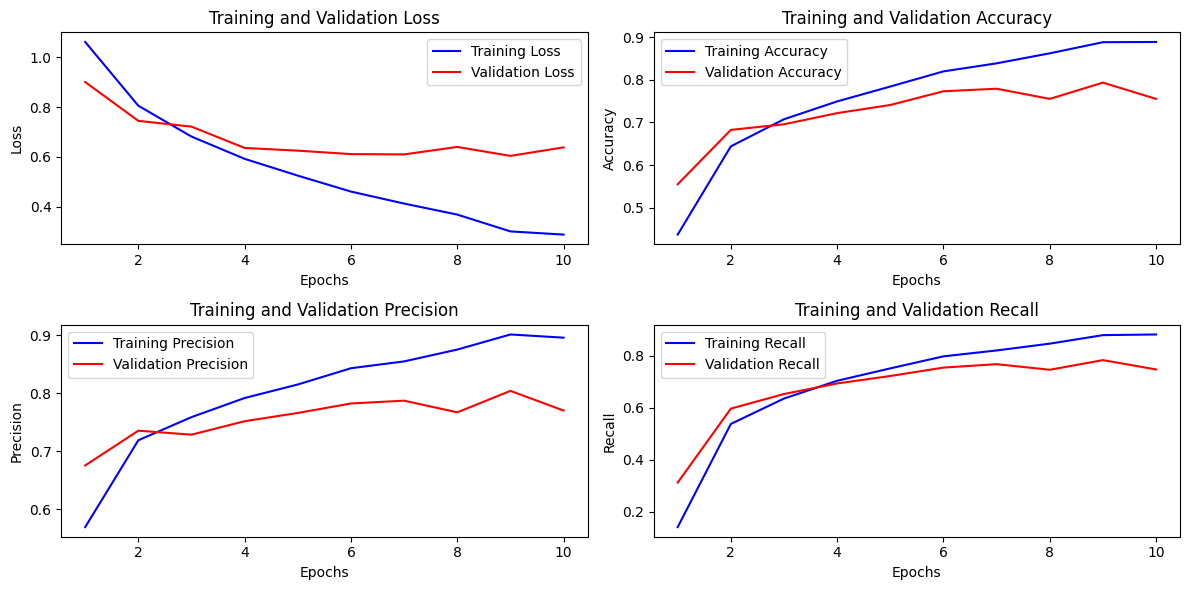

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned from model.fit

# Extract metrics
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation precision
plt.subplot(2, 2, 3)
plt.plot(epochs, history_dict['precision'], 'b-', label='Training Precision')
plt.plot(epochs, history_dict['val_precision'], 'r-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training and validation recall
plt.subplot(2, 2, 4)
plt.plot(epochs, history_dict['recall'], 'b-', label='Training Recall')
plt.plot(epochs, history_dict['val_recall'], 'r-', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


# Confusion Matrix

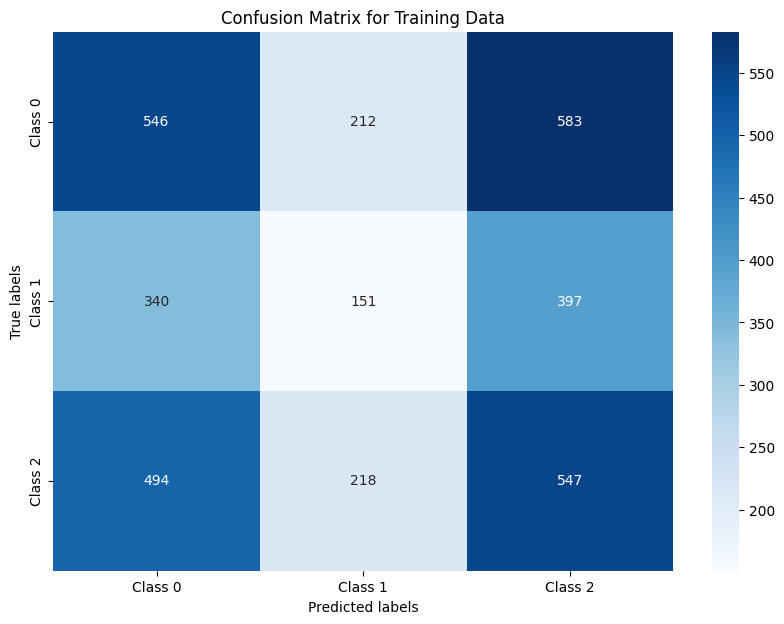

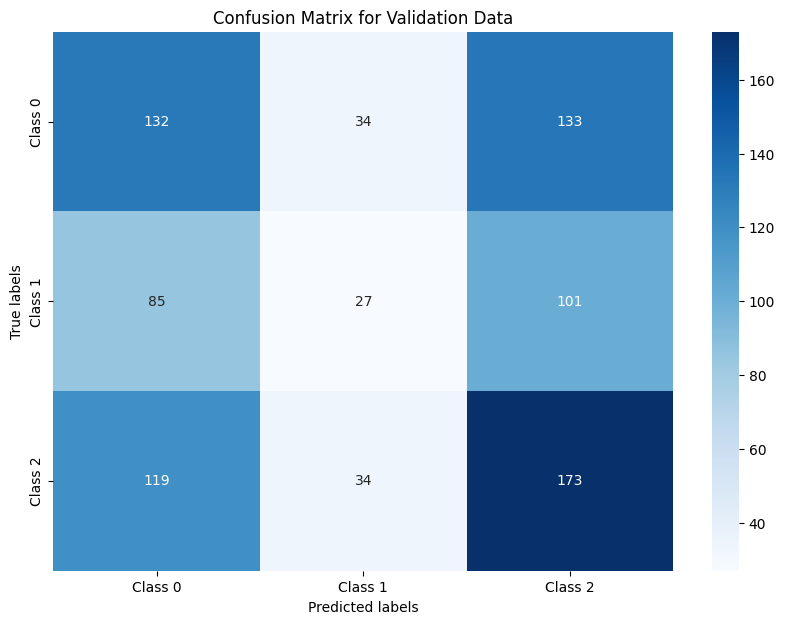

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix using seaborn heatmap.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    class_names (list): List of class names.
    title (str): Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Make predictions on training and validation (test) datasets
train_predictions = model.predict(train_dataset)
val_predictions = model.predict(val_dataset)

# Get true labels
train_labels = np.concatenate([y for x, y in train_dataset], axis=0)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
train_labels=np.argmax(train_labels, axis=1)
val_labels =np.argmax(val_labels, axis=1)
# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Define class names (replace with your actual class names)
class_names = ['Class 0', 'Class 1', 'Class 2']

# Plot confusion matrix for training data
plot_confusion_matrix(train_labels, train_pred_labels, class_names, title='Confusion Matrix for Training Data')

# Plot confusion matrix for validation (test) data
plot_confusion_matrix(val_labels, val_pred_labels, class_names, title='Confusion Matrix for Validation Data')


## Retrain the model from the 11 th epoch

In [ ]:
import tensorflow as tf
from mlp_mixer_keras import MixerBlock  # Import your custom layer

# Define custom objects
custom_objects = {
    'MixerBlock': MixerBlock  # Add any other custom objects if needed
}

# Load the previously saved model with custom objects
model_save_path = '/content/Weights/best_model.h5'
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects=custom_objects)

# Prepare the dataset (assuming train_dataset and val_dataset are defined)
# Note: Ensure your datasets are correctly preprocessed and defined

# Continue training from epoch 11
history = loaded_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,                               # Total number of epochs for this training session
    initial_epoch=10,                       # Start training from the 11th epoch
    batch_size=32,                         # Adjust batch size as needed
    # Optional: include callbacks if needed
)

# Save the model again if required
loaded_model.save('/content/Weights/continued_training_model.h5')
print('Model retrained and saved successfully')


Epoch 11/40
109/109 [==============================] - 112s 1s/step - loss: 0.2334 - accuracy: 0.9232 - precision: 0.9274 - recall: 0.9186 - val_loss: 0.5509 - val_accuracy: 0.8186 - val_precision: 0.8255 - val_recall: 0.8126
Epoch 12/40
109/109 [==============================] - 104s 950ms/step - loss: 0.1991 - accuracy: 0.9352 - precision: 0.9390 - recall: 0.9318 - val_loss: 0.5337 - val_accuracy: 0.8305 - val_precision: 0.8339 - val_recall: 0.8270
Epoch 13/40
109/109 [==============================] - 103s 935ms/step - loss: 0.1793 - accuracy: 0.9409 - precision: 0.9441 - recall: 0.9392 - val_loss: 0.5301 - val_accuracy: 0.8294 - val_precision: 0.8323 - val_recall: 0.8294
Epoch 14/40
109/109 [==============================] - 102s 927ms/step - loss: 0.1456 - accuracy: 0.9510 - precision: 0.9523 - recall: 0.9493 - val_loss: 0.5496 - val_accuracy: 0.8365 - val_precision: 0.8401 - val_recall: 0.8341
Epoch 15/40
109/109 [==============================] - 103s 943ms/step - loss: 0.1271 -

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned from model.fit

# Extract metrics
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation precision
plt.subplot(2, 2, 3)
plt.plot(epochs, history_dict['precision'], 'b-', label='Training Precision')
plt.plot(epochs, history_dict['val_precision'], 'r-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training and validation recall
plt.subplot(2, 2, 4)
plt.plot(epochs, history_dict['recall'], 'b-', label='Training Recall')
plt.plot(epochs, history_dict['val_recall'], 'r-', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
